<a href="https://colab.research.google.com/github/SERVIR/RX_fires/blob/main/EIA/OBIWAN_Rx_Fire_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install requests ipywidgets

In [33]:
import pandas as pd

In [34]:
import ee
import geemap

In [35]:
# Authenticate and initialize Earth Engine
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='servir-sco-assets')
Map = geemap.Map()

# ESA_CCI_AGB approach

In [36]:

# Load the LLP image
LLP = ee.Image("projects/servir-sco-assets/assets/Rx_Fire/EO_Inputs/LEO_extantLLP_significance")

# Make binary mask: all LLP classes -> 1, background -> 0
LLP_binary = LLP.gt(0).selfMask()

# Define a function to process an AOI
def processAOI(aoi, name):
    """
    Clips the LLP image to an AOI, vectorizes it, and dissolves polygons.
    """

    # Clip LLP
    llp_clip = LLP_binary.clip(aoi)

    # Vectorize LLP
    llp_vec = llp_clip.reduceToVectors(
        geometry=aoi,
        scale=30,
        eightConnected=True,
        geometryType='polygon',
        bestEffort=True,
        maxPixels=1e13
    )

    # Dissolve LLP polygons
    llp_dissolved = llp_vec.union(1)

    return llp_dissolved

# Example usage:
# Define an AOI (replace with your own geometry)
aoi = ee.Geometry.Polygon([
    [[-120.5, 37.0], [-120.5, 36.8], [-120.2, 36.8], [-120.2, 37.0], [-120.5, 37.0]]
])

# Process AOI
result = processAOI(aoi, "example_AOI")

EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')


EIA_CS1 = processAOI(EIA_CS1, "example_AOI")
EIA_CS2 = processAOI(EIA_CS2, "example_AOI")
EIA_CS3 = processAOI(EIA_CS3, "example_AOI")




In [37]:
palette = ["#C6ECAE","#A1D490","#7CB970","#57A751","#348E32",
           "#267A29","#176520","#0C4E15","#07320D","#031807"]

# Create a map
Map = geemap.Map(center=[0, 0], zoom=2)

# Load AGB ImageCollection
agb = ee.ImageCollection('projects/sat-io/open-datasets/ESA/ESA_CCI_AGB')

# Add 2020 AGB layer
agb_2020 = agb.filterDate('2019-01-01', '2020-01-01').first().select(['AGB'])
Map.addLayer(agb_2020, {'min':1, 'max':450, 'palette': palette}, 'Above Ground Biomass 2020')


# EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
# EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
# EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# print("EIA_CS1:", EIA_CS1.size().getInfo())
# print("EIA_CS2:", EIA_CS2.size().getInfo())
# print("EIA_CS3:", EIA_CS3.size().getInfo())

Map.addLayer(EIA_CS1, {}, "EIA_CS1")
Map.addLayer(EIA_CS2, {}, "EIA_CS2")
Map.addLayer(EIA_CS3, {}, "EIA_CS3")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

https://gee-community-catalog.org/projects/cci_agb/
Above ground biomass (AGB, unit: tons/ha i.e., Mg/ha) (raster dataset).
This is defined as the mass, expressed as oven-dry weight of the woody parts (stem, bark, branches and twigs)
of all living trees excluding stump and roots

In [38]:
# Compute pixel area in hectares
pixel_area_ha = ee.Image.pixelArea().divide(10000)

# Biomass in Mg (tons) per pixel for 2019
agb_2019 = agb.filterDate('2018-01-01', '2019-01-01') .first().select(['AGB'])

# Get projection info
proj = agb_2019.projection()
# print('Projection:', proj.getInfo())
# print('Nominal scale (m):', proj.nominalScale().getInfo())

# Multiply by pixel area to get Mg per pixel
agb_Mg_per_pixel = agb_2019.multiply(pixel_area_ha)

# Convert Mg to short tons
agb_tons_per_pixel = agb_Mg_per_pixel.multiply(1.10231)

In [39]:
# #https://gee-community-catalog.org/projects/cci_agb/
# # Above ground biomass (AGB, unit: tons/ha i.e., Mg/ha) (raster dataset).
# # This is defined as the mass, expressed as oven-dry weight of the woody parts (stem, bark, branches and twigs)
# #of all living trees excluding stump and roots

# # Compute pixel area in hectares
# pixel_area_ha = ee.Image.pixelArea().divide(10000)

# # Biomass in Mg (tons) per pixel for 2019
# agb_2019 = agb.filterDate('2019-01-01', '2019-01-02').first().select(['AGB'])

# # Get projection info
# proj = agb_2019.projection()
# # print('Projection:', proj.getInfo())
# # print('Nominal scale (m):', proj.nominalScale().getInfo())

# # Multiply by pixel area to get Mg per pixel
# agb_Mg_per_pixel = agb_2019.multiply(pixel_area_ha)

# # Convert Mg to short tons
# agb_tons_per_pixel = agb_Mg_per_pixel.multiply(1.10231)

# # Function to sum biomass per polygon
# # def add_total_biomass(fc, name):
# #     reduced = agb_tons_per_pixel.reduceRegions(
# #         collection=fc,
# #         reducer=ee.Reducer.sum(),
# #         scale=100
# #     )
# #     reduced = reduced.map(lambda f: f.set({
# #         'Source': name,
# #         'Total_AGB_tons': f.get('sum')
# #     }))
# #     return reduced


# def add_total_biomass(fc, name):
#     reduced = agb_tons_per_pixel.reduceRegions(
#         collection=fc,
#         reducer=ee.Reducer.sum(),
#         scale=100
#     )

#     # Map over features to calculate area and agb_per_acre
#     def add_attributes(f):
#         area_m2 = f.geometry().area()
#         area_acres = area_m2.divide(4046.86)
#         agb_sum = ee.Number(f.get('sum'))
#         return f.set({
#             'Source': name,
#             'Total_AGB_tons': agb_sum,
#             'agb_per_acre': agb_sum.divide(area_acres)
#         })

#     reduced = reduced.map(add_attributes)
#     return reduced







# # Apply function to feature collections
# results1 = add_total_biomass(EIA_CS1, 'EIA_CS1')
# results2 = add_total_biomass(EIA_CS2, 'EIA_CS2')
# results3 = add_total_biomass(EIA_CS3, 'EIA_CS3')

# # Merge results
# # all_results = results1.merge(results2).merge(results3)

# # print('All Results with total biomass (tons):', all_results.size().getInfo())

# # # Export to Google Drive
# # task = ee.batch.Export.table.toDrive(
# #     collection=all_results,
# #     description='EIA_AGB_total_tons_2019',
# #     fileFormat='CSV'
# # )
# # task.start()

# # Display the map
# # Map


agd and std per acre

In [40]:
def add_total_biomass(fc, name):
    # Use sum + mean + stdDev reducers
    reducer = (ee.Reducer.sum().setOutputs(['AGB_sum'])
               .combine(ee.Reducer.mean().setOutputs(['AGB_mean']), sharedInputs=True)
               .combine(ee.Reducer.stdDev().setOutputs(['AGB_stdDev']), sharedInputs=True))

    reduced = agb_tons_per_pixel.reduceRegions(
        collection=fc,
        reducer=reducer,
        scale=100
    )

    def add_attributes(f):
        area_m2 = f.geometry().area()
        area_acres = area_m2.divide(4046.86)
        agb_sum = ee.Number(f.get('AGB_sum'))
        agb_std = ee.Number(f.get('AGB_stdDev'))

        agb_per_acre = agb_sum.divide(area_acres)
        agb_std_per_acre = agb_std.divide(area_acres)

        return f.set({
            'Source': name,
            'Total_AGB_tons': agb_sum,
            'agb_per_acre': agb_per_acre,
            'stdDev_AGB_tons_per_pixel': agb_std,
            'stdDev_AGB_per_acre': agb_std_per_acre
        })

    return reduced.map(add_attributes)


In [41]:
# Apply function to feature collections
results1 = add_total_biomass(EIA_CS1, 'EIA_CS1')
results2 = add_total_biomass(EIA_CS2, 'EIA_CS2')
results3 = add_total_biomass(EIA_CS3, 'EIA_CS3')

# Merge them
all_results = results1.merge(results2).merge(results3)

# # Inspect one feature
# print(all_results.first().toDictionary().getInfo())

In [42]:
all_results

In [43]:
# Convert to GeoPandas GeoDataFrame
gdf = geemap.ee_to_gdf(all_results)

# Display the head of the GeoDataFrame
print(gdf.head())
# You can also plot the GeoDataFrame
# gdf.plot()
gdf["Method"] = "ESA"

                                            geometry    AGB_mean  AGB_stdDev  \
0  MULTIPOLYGON (((-87.48139 32.99994, -87.48106 ...  119.898607   65.485257   
1  MULTIPOLYGON (((-86.96087 32.77479, -86.96119 ...  151.511572   51.757404   
2  POLYGON ((-87.33549 32.98164, -87.33552 32.981...  113.453850   60.967180   

        AGB_sum   Source  Total_AGB_tons  agb_per_acre  stdDev_AGB_per_acre  \
0  37644.401085  EIA_CS1    37644.401085     57.820607             0.100583   
1  68398.265275  EIA_CS2    68398.265275     72.995228             0.055236   
2  29833.023435  EIA_CS3    29833.023435     54.836935             0.112066   

   stdDev_AGB_tons_per_pixel  
0                  65.485257  
1                  51.757404  
2                  60.967180  


In [44]:
print(gdf.columns.tolist())


['geometry', 'AGB_mean', 'AGB_stdDev', 'AGB_sum', 'Source', 'Total_AGB_tons', 'agb_per_acre', 'stdDev_AGB_per_acre', 'stdDev_AGB_tons_per_pixel', 'Method']


In [45]:
gdf

,geometry,AGB_mean,AGB_stdDev,AGB_sum,Source,Total_AGB_tons,agb_per_acre,stdDev_AGB_per_acre,stdDev_AGB_tons_per_pixel,Method
0,"MULTIPOLYGON (((-87.48139 32.99994, -87.48106 ...",119.898607,65.485257,37644.401085,EIA_CS1,37644.401085,57.820607,0.100583,65.485257,ESA
1,"MULTIPOLYGON (((-86.96087 32.77479, -86.96119 ...",151.511572,51.757404,68398.265275,EIA_CS2,68398.265275,72.995228,0.055236,51.757404,ESA
2,"POLYGON ((-87.33549 32.98164, -87.33552 32.981...",113.453850,60.967180,29833.023435,EIA_CS3,29833.023435,54.836935,0.112066,60.967180,ESA


In [46]:
# import matplotlib.pyplot as plt

# # Aggregate total AGB by Source
# agg = gdf.groupby("Source")["agb_per_acre"].sum().reset_index()

# # Bar chart
# plt.figure(figsize=(10,6))
# plt.bar(agg["Source"], agg["agb_per_acre"], color="pink", edgecolor="black")

# plt.xlabel("Source")
# plt.ylabel("Total AGB (tons)")
# plt.title("Total AGB by Source")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


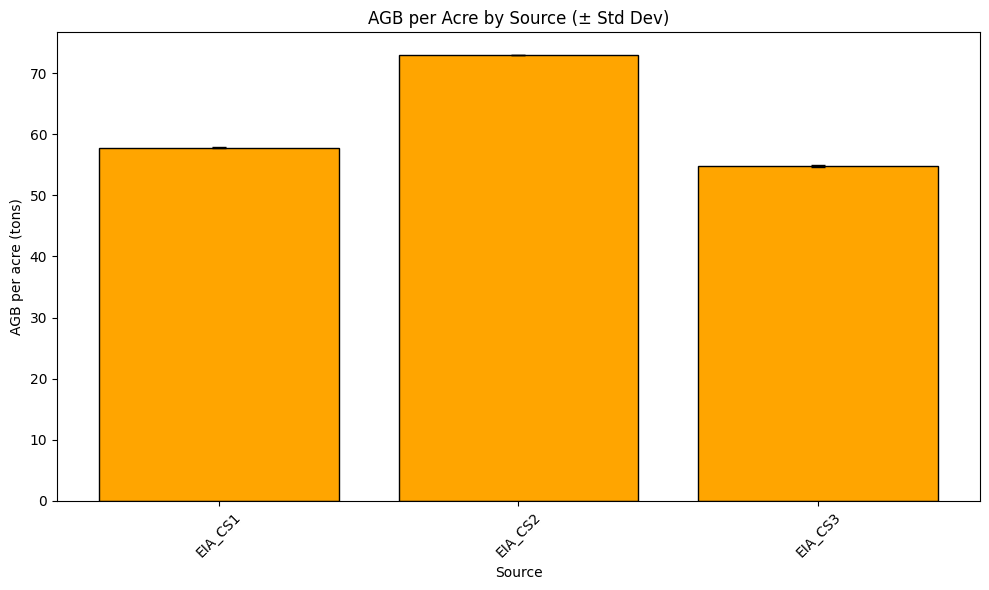

In [47]:
import matplotlib.pyplot as plt

# Aggregate mean and stdDev by Source
agg = gdf.groupby("Source").agg(
    mean_agb_per_acre=("agb_per_acre", "mean"),
    std_agb_per_acre=("stdDev_AGB_per_acre", "mean")  # or "std" if you want across-polygons variability
).reset_index()

# Bar chart with error bars
plt.figure(figsize=(10,6))
plt.bar(
    agg["Source"],
    agg["mean_agb_per_acre"],
    yerr=agg["std_agb_per_acre"],
    capsize=5,
    color="orange",
    edgecolor="black"
)

plt.xlabel("Source")
plt.ylabel("AGB per acre (tons)")
plt.title("AGB per Acre by Source (± Std Dev)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# OBIWAN approach

In [48]:
import ee, json


# Your FeatureCollections
EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# Convert to GeoJSON (Python dicts)
geojson_fc1 = EIA_CS1.getInfo()
geojson_fc2 = EIA_CS2.getInfo()
geojson_fc3 = EIA_CS3.getInfo()


In [49]:
import requests

class ObiwanClient:
    def __init__(self, base_url="https://obiwan-alabama-api-5026633953.us-west1.run.app"):
        self.base_url = base_url.rstrip('/')

    def estimate_biomass_stock(self, year, geojson_payload, calibration_flag=False):
        # New endpoint (shorter path)
        endpoint = f"{self.base_url}/estimate_biomass_state_geojson/{year}"
        params = {"use_calibration": str(calibration_flag).lower()}  # true/false
        headers = {"Content-Type": "application/json"}

        response = requests.post(endpoint, params=params, json=geojson_payload, headers=headers)
        response.raise_for_status()
        return response.json()


In [50]:
client = ObiwanClient()

year = 2018
calibration_flag = True  # or True

In [51]:
# estimates_fc1 = client.estimate_biomass_stock(year, geojson_fc1, calibration_flag)
# # estimates_fc2 = client.estimate_biomass_stock(year, geojson_fc2, calibration_flag)
# # estimates_fc3 = client.estimate_biomass_stock(year, geojson_fc3, calibration_flag)
# print(estimates_fc1)
# # pd.DataFrame([estimates_fc1])
# # pd.DataFrame([estimates_fc2])
# # pd.DataFrame([estimates_fc3])

In [52]:
estimates_fc1 = client.estimate_biomass_stock(year, geojson_fc1, calibration_flag)
print(estimates_fc1)

{'AGBD': 205.30474910525953, 'area': 5152478.115234375, 'asset_version': '1.0', 'stdAGBD': 4.33210259054312, 'use_calibration': True, 'year': 2018}


In [53]:
estimates_fc2 = client.estimate_biomass_stock(year, geojson_fc2, calibration_flag)
print(estimates_fc2)

{'AGBD': 203.93166803552944, 'area': 10821259.333984375, 'asset_version': '1.0', 'stdAGBD': 2.8305852774165703, 'use_calibration': True, 'year': 2018}


In [54]:
estimates_fc3 = client.estimate_biomass_stock(year, geojson_fc3, calibration_flag)
print(estimates_fc2)

{'AGBD': 203.93166803552944, 'area': 10821259.333984375, 'asset_version': '1.0', 'stdAGBD': 2.8305852774165703, 'use_calibration': True, 'year': 2018}


In [55]:
df1 = pd.DataFrame([estimates_fc1])#.insert(1,"Source",["EIA_CS1"])
df1["Source"] = "EIA_CS1"
df1["Method"] = "OBIWAN"
df2 = pd.DataFrame([estimates_fc2])#.insert(1,"Source",["EIA_CS2"])
df2["Source"] = "EIA_CS2"
df2["Method"] = "OBIWAN"
df3 = pd.DataFrame([estimates_fc3])#.insert(1,"Source",["EIA_CS3"])
df3["Source"] = "EIA_CS3"
df3["Method"] = "OBIWAN"

In [56]:
combined_df_append = pd.concat([df1, df2, df3], ignore_index=True)
print(combined_df_append)

         AGBD          area asset_version   stdAGBD  use_calibration  year  \
0  205.304749  5.152478e+06           1.0  4.332103             True  2018   
1  203.931668  1.082126e+07           1.0  2.830585             True  2018   
2  208.813435  4.160505e+06           1.0  4.734794             True  2018   

    Source  Method  
0  EIA_CS1  OBIWAN  
1  EIA_CS2  OBIWAN  
2  EIA_CS3  OBIWAN  


In [57]:
# Conversion factor
hectares_to_acres = 2.47105

# Create new column
combined_df_append['agb_per_acre'] = combined_df_append['AGBD'] / hectares_to_acres

# Optional: convert stdAGBD similarly if you want error bars
combined_df_append['std_agb_per_acre'] = combined_df_append['stdAGBD'] / hectares_to_acres


combined_df_append
# print(combined_df_append[['Source', 'AGBD', 'agb_per_acre', 'stdAGBD', 'std_agb_per_acre']])


,AGBD,area,asset_version,stdAGBD,use_calibration,year,Source,Method,agb_per_acre,std_agb_per_acre
0,205.304749,5.152478e+06,1.0,4.332103,True,2018,EIA_CS1,OBIWAN,83.084013,1.753142
1,203.931668,1.082126e+07,1.0,2.830585,True,2018,EIA_CS2,OBIWAN,82.528345,1.145499
2,208.813435,4.160505e+06,1.0,4.734794,True,2018,EIA_CS3,OBIWAN,84.503929,1.916106


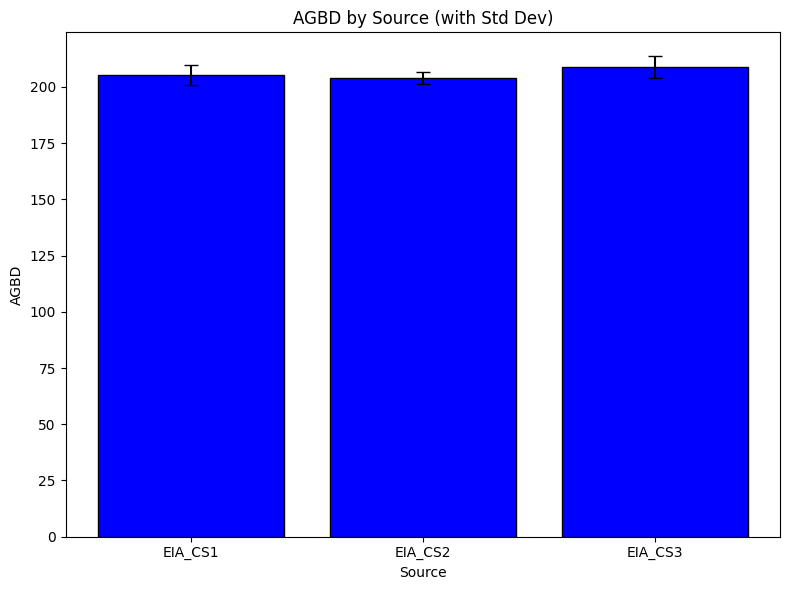

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Bar plot with error bars
plt.bar(
    combined_df_append["Source"],
    combined_df_append["AGBD"],
    yerr=combined_df_append["stdAGBD"],  # <-- add std deviation here
    capsize=5,                           # adds "caps" to the error bars
    color="blue",
    edgecolor="black"
)

plt.xlabel("Source")
plt.ylabel("AGBD")
plt.title("AGBD by Source (with Std Dev)")
plt.tight_layout()
plt.show()


In [59]:
combined_df_append

,AGBD,area,asset_version,stdAGBD,use_calibration,year,Source,Method,agb_per_acre,std_agb_per_acre
0,205.304749,5.152478e+06,1.0,4.332103,True,2018,EIA_CS1,OBIWAN,83.084013,1.753142
1,203.931668,1.082126e+07,1.0,2.830585,True,2018,EIA_CS2,OBIWAN,82.528345,1.145499
2,208.813435,4.160505e+06,1.0,4.734794,True,2018,EIA_CS3,OBIWAN,84.503929,1.916106


Cross compare

In [60]:
esa_df = gdf
obiwan_df = combined_df_append

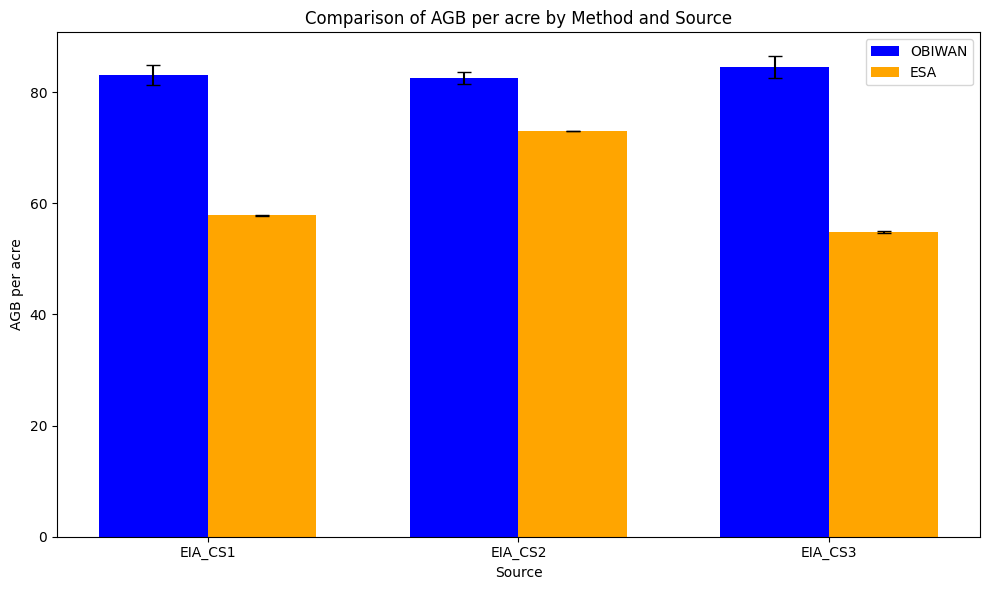

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# First, ensure column names match
obiwan_df['Source'] = obiwan_df['Source'].astype(str)
esa_df['Source'] = esa_df['Source'].astype(str)

# Prepare data for plotting
obiwan_plot = obiwan_df[['Source', 'agb_per_acre', 'std_agb_per_acre']]
esa_plot = esa_df[['Source', 'agb_per_acre', 'stdDev_AGB_per_acre']].rename(columns={'stdDev_AGB_per_acre':'std_agb_per_acre'})

# Add a column to identify the method
obiwan_plot['Method'] = 'OBIWAN'
esa_plot['Method'] = 'ESA'

# Combine both datasets
plot_df = pd.concat([obiwan_plot, esa_plot], axis=0)

# Pivot for plotting grouped bars
plot_pivot = plot_df.pivot(index='Source', columns='Method', values=['agb_per_acre','std_agb_per_acre'])
plot_pivot = plot_pivot.sort_index()  # optional, ensures sources are in order

# Plotting
sources = plot_pivot.index
x = np.arange(len(sources))  # the label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(10,6))

# Obiwan bars
ax.bar(x - width/2, plot_pivot['agb_per_acre']['OBIWAN'], width, yerr=plot_pivot['std_agb_per_acre']['OBIWAN'],
       capsize=5, label='OBIWAN', color='blue')

# ESA bars
ax.bar(x + width/2, plot_pivot['agb_per_acre']['ESA'], width, yerr=plot_pivot['std_agb_per_acre']['ESA'],
       capsize=5, label='ESA', color='orange')

# Labels and title
ax.set_xlabel('Source')
ax.set_ylabel('AGB per acre')
ax.set_title('Comparison of AGB per acre by Method and Source')
ax.set_xticks(x)
ax.set_xticklabels(sources)
ax.legend()

plt.tight_layout()
plt.show()


In [62]:
plot_df

,Source,agb_per_acre,std_agb_per_acre,Method
0,EIA_CS1,83.084013,1.753142,OBIWAN
1,EIA_CS2,82.528345,1.145499,OBIWAN
2,EIA_CS3,84.503929,1.916106,OBIWAN
0,EIA_CS1,57.820607,0.100583,ESA
1,EIA_CS2,72.995228,0.055236,ESA
2,EIA_CS3,54.836935,0.112066,ESA
